In [11]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report


In [1]:
from google.colab import files
files.upload()


Saving archive (4).zip to archive (4).zip


In [7]:
!unzip -q "archive (4).zip"


In [8]:
!find . -maxdepth 3 -type d | head -n 50


.
./.config
./.config/logs
./.config/logs/2025.12.11
./.config/configurations
./Brain_Tumor_Datasets
./Brain_Tumor_Datasets/train
./Brain_Tumor_Datasets/train/no
./Brain_Tumor_Datasets/train/yes
./Brain_Tumor_Datasets/test
./Brain_Tumor_Datasets/test/no
./Brain_Tumor_Datasets/test/yes
./sample_data


In [9]:
TRAIN_DIR = "Brain_Tumor_Datasets/train"
TEST_DIR  = "Brain_Tumor_Datasets/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = train_ds.class_names
class_names


Found 7012 files belonging to 2 classes.
Using 5610 files for training.
Found 7012 files belonging to 2 classes.
Using 1402 files for validation.


['no', 'yes']

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)


Found 1752 files belonging to 2 classes.


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])


In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [19]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.8307 - loss: 0.3770 - val_accuracy: 0.9551 - val_loss: 0.1464
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9444 - loss: 0.1630 - val_accuracy: 0.9522 - val_loss: 0.1266
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9583 - loss: 0.1231 - val_accuracy: 0.9544 - val_loss: 0.1189
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9605 - loss: 0.1196 - val_accuracy: 0.9579 - val_loss: 0.1132
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9686 - loss: 0.0945 - val_accuracy: 0.9636 - val_loss: 0.1003
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9694 - loss: 0.0848 - val_accuracy: 0.9650 - val_loss: 0.0942
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9721 - loss: 0.0786 - val_accuracy: 0.9708 - val_loss: 0.0847
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9731 - loss: 0.0791 - val_accu

In [20]:
y_true, y_pred = [], []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).flatten()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

          no       0.98      0.94      0.96       717
         yes       0.96      0.99      0.97      1035

    accuracy                           0.97      1752
   macro avg       0.97      0.96      0.96      1752
weighted avg       0.97      0.97      0.97      1752



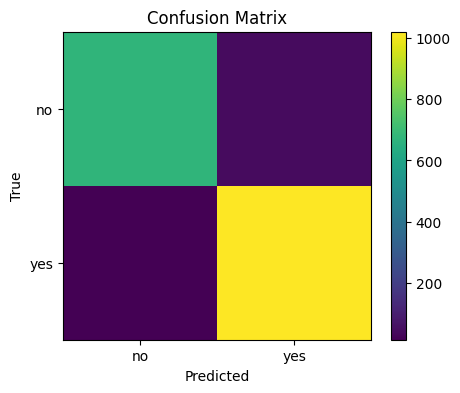

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
model.save("brain_mri_finetuned_model.h5")
